# Image Sampling
_This notebook is part of the collection accompanying the talk "Analyzing Satellite Images With Python Scientific Stack" by Milos Miljkovic given at PyData NYC 2014. The content is BSD licensed._

Oftentimes, it is necessary to select a subset of pixels from an image. The reductive procedure in which a number of pixels are marked as a representative feature of the image is called sampling. Type of sampling depends on intended use of the subset - image size rescaling, signal processing, or machine learning have different requirements. Strategies and algorithms for sampling can be divided into two broad categories:

* Applying a mask made of geometrically regular patterns.
* Applying a mask made of algorithmically random selected points.

In the first case, repeating, regular patterns may have negative effect on subsequent image analyses and processing. The second way of selecting sample pixels necessitates use of algorithms depending on randomness. This introduced randomness should be "evenly" distributed across the image with no big gaps or tightly spaced pixels.

In this notebook we will explore two types of sampling:

* Uniform random sampling.
* Poisson-disc sampling.

## Uniform Random Sampling

This algorithm uses random numbers from uniform distribution to select (x,y) coordinates of sampled pixels. Unfortunately, the result of the uniform random sampling is poor. Pixels tend to be selected in such way that heavy under- and over-sampling occurs. Points have a tendency to either clustering together or are spread wide apart.

## Poisson-disc Sampling

Unlike random sampling, this algorithm avoids scattering selection points across the image. Selection set is incrementally built from existing points by applying a set of rules imposing distance and distribution constrains.

The implementation of the Poisson-disc sampling presented in this notebook is based on the [Bridson paper](http://www.cs.ubc.ca/~rbridson/docs/bridson-siggraph07-poissondisk.pdf) describing an efficient _O(n)_ algorithm, and Java code by [Jason Davies](http://www.jasondavies.com/poisson-disc/), one of D3 developers.

In [1]:
# To install watermark extension execute:
# %install_ext https://raw.githubusercontent.com/HyperionAnalytics/watermark/master/watermark.py
%load_ext watermark

ModuleNotFoundError: No module named 'watermark'

In [2]:
%watermark -v -m -p numpy,scipy,matplotlib

CPython 3.4.2
IPython 2.3.1

numpy 1.9.1
scipy 0.14.0
matplotlib 1.4.2

compiler   : GCC 4.2.1 (Apple Inc. build 5577)
system     : OS X 10.10.1
release    : 14.0.0
machine    : x86_64
processor  : Intel(R) Core(TM) i7-3740QM CPU @ 2.70GHz
CPU cores  : 8
interpreter: 64bit


In [2]:
import math
import random
import numpy as np
from random import random
from matplotlib import pyplot as plt
from matplotlib.collections import PolyCollection
from scipy.spatial import Voronoi, voronoi_plot_2d
from IPython.display import HTML

The best visual explanation of how the algorithm works can be found [in the post](http://bost.ocks.org/mike/algorithms/) by Mike Bostock's - the grand master of visualizing algorithms.

In [3]:
HTML('<iframe src=http://bl.ocks.org/mbostock/raw/dbb02448b0f93e4c82c3 '
     'style="background-color: white;" width=970 height=520></iframe>')

> Red dots represent “active” samples. At each iteration, one is selected randomly from the set of all active samples. Then, up to k candidate samples (shown as hollow black dots), are randomly generated within an annulus surrounding the selected sample.

> The annulus extends from radius r to 2r, where r is the minimum allowable distance between any two samples. Candidate samples within radius r from an existing sample are rejected; this “exclusion zone” is shown in gray, along with a black line connecting the rejected candidates with the existing sample that is too close. If the candidate is acceptable, it is added as a new active sample.

> A background grid of size r/√2 is used to accelerate the distance check for each candidate. Because each cell can only contain at most one sample, only a fixed number of neighboring cells need to be inspected.

> If none of the k candidates are acceptable, the selected active sample is marked as inactive and will no longer be used to generate candidates. Inactive samples are shown in black.

> When no samples remain active, the algorithm ends.
> When no samples remain active, the algorithm ends.
<br>
<br>
> _Mike Bostock_

In [4]:
%matplotlib inline

In [5]:
plt.rcParams.update({'figure.facecolor': 'w',
                     'font.size': 14,
                     'figure.figsize': [12.0, 9.0]})

In [6]:
def random_select(img_width, img_hight, num_pts):
    """
    Select random points in image
    Input:
    img_width - integer, 1 to n
    img_hight - integer, 1 to n
    num_pts - integer, 1 to img_width*img_hight
    Output:
    sample_pts_array - floats array, shape[img_width*img_hight, 2]
    """
    lst = []
    for n in range(num_pts):
        lst.append([random()*img_width, random()*img_hight])
        
    sample_pts_array = np.asarray(lst)
    
    return sample_pts_array

In [7]:
def poisson_disc_select(img_width, img_hight, r, n_try):
    """
    Select points from Poisson disc
    Input:
    img_width - integer, 1 to n
    img_hight - integer, 1 to n
    r - minimum didtance between two points, float
    n_try - number of randomly sampled points per try, integer, 1 - n
    Output:
    sample_pts_array - floats array, shape[img_width*img_hight, 2]
    """
    r_square = r**2
    A = 3*r_square
    cell_size = r/math.sqrt(2)
    grid_width = int(math.ceil(img_width/cell_size))
    grid_hight = int(math.ceil(img_hight/cell_size))
    grid = [None]*grid_width*grid_hight
    queue = list()
    queue_size = 0
    sample_size = 0
    
    def distance(x, y):
        x_idx = int(x/cell_size)
        y_idx = int(y/cell_size)
        x0 = max(x_idx-2, 0)
        y0 = max(y_idx-2, 0)
        x1 = min(x_idx+3, grid_width)
        y1 = min(y_idx+3, grid_hight)
        
        for w in range(y0, y1):
            p = w*grid_width
            for h in range(x0, x1):
                if grid[p+h]:
                    s = grid[p+h]
                    dx = s[0]-x
                    dy = s[1]-y
                    if dx**2 + dy**2 < r_square:
                        return False
        return True
    
    def set_point(x, y):
        nonlocal queue, grid, queue_size, sample_size
        s = [x, y]
        queue.append(s)
        grid[grid_width*int(y/cell_size) + int(x/cell_size)] = s;
        queue_size += 1
        sample_size += 1
        return s
    
    # Set first data point
    if sample_size == 0:
        x = random()*img_width
        y = random()*img_hight
        set_point(x, y)
        
    while queue_size:
        x_idx = int(random()*queue_size)
        s = queue[x_idx]
        
        # Generate random point in annulus [r, 2r]
        for y_idx in range(0, n_try):
            a = 2*math.pi*random()
            b = math.sqrt(A*random() + r_square)
            
            x = s[0] + b*math.cos(a)
            y = s[1] + b*math.sin(a)
            
            # Set point if farther than r from any other point
            if 0 <= x and x < img_width and 0 <= y and y < img_hight and distance(x, y):
                set_point(x, y)
                
        del queue[x_idx]
        queue_size -= 1
                
    sample_pts = list(filter(None, grid))
    sample_pts_array = np.asfarray(sample_pts)
    
    return sample_pts_array

In [8]:
def plot_vor(vor, x, y, offset, title):
    """
    Plot Voronoi diagram
    Input:
    vor - Voronoi object
    x - x axis limit max, float
    y - y axis limit max, float
    offset - x,y limits offset, float
    title - title, string
    """
    voronoi_plot_2d(vor)

    plt.xlim(0-offset, x+offset)
    plt.ylim(0-offset, y+offset)
    plt.title(title)
    plt.show()

In [9]:
def plot_scatter(pts, x, y, title):
    """
    Scatter plot
    Input:
    pts - floats array
    title - string
    """
    p = plt.scatter(pts[:, 0], pts[:, 1], marker='o', edgecolors='k', linewidths=1.0)
    p.set_facecolor('k')
    plt.xlim(0, x)
    plt.ylim(0, y)
    plt.title(title)
    plt.show()

In [10]:
def plot_hist(a, bins, color, title):
    """
    Histogram plot
    Input:
    a - list of floats
    bins - integer
    title - string
    """
    plt.subplots()
    plt.hist(a, bins, color=color)
    plt.title(title)
    plt.show()

In [11]:
def vor_patches(vor, x, y, fc, title_prefix):
    """
    Plot Voronoi patches
    Input:
    vor - Voronoi object
    x - integer
    y - integer
    fc - patch face color, string
    title - string
    Output:
    nv - Finite Voroni patches with vertices within image boundaries, list of floats arrays
    """
    nv = []
    for region in vor.regions[1::]:
        if all(v >= 0 for v in region):
            b = vor.vertices[region, :]        
            if np.all(0 <= b[:, 0]) and np.all(x >= b[:, 0]) and \
               np.all(0 <= b[:, 1]) and np.all(y >= b[:, 1]):
                nv.append(b)
                
    fig, ax = plt.subplots()
    coll = PolyCollection(nv, edgecolors='w', facecolors=fc)
    ax.add_collection(coll)
    plt.xlim(0, x)
    plt.ylim(0, y)
    plt.title(title_prefix + ' - Finite patches with vertices within image boundaries\n'
              'Number of patches: ' + str(len(nv)))
    plt.show()
    
    return nv

In [12]:
def sort_patch_vert(patches):
    """
    Sort Voronoi patch verteces counter clockwise
    Input:
    patches - list of floats array
    Output:
    patches_sorted - list of floats array
    """
    patches_sorted = []
    for p in patches:
        if p.shape[0] != 0:
            c = p.mean(axis=0)
            angles = np.arctan2(p[:,1] - c[1], p[:,0] - c[0])
            p_sorted = p[np.argsort(angles)]
            patches_sorted.append(p_sorted)
        
    return patches_sorted

In [13]:
def polygon_area(vertices):
    """
    Calculate polygon area (shoelace algorithm)
    Input:
    vertices - floats array
    Output:
    area - float
    """
    n = len(vertices)
    area = 0.0
    for i in range(n):
        j = (i + 1) % n
        area += vertices[i][0] * vertices[j][1]
        area -= vertices[j][0] * vertices[i][1]
    area = abs(area) / 2.0
    return area

In [14]:
def patches_area(patches):
    """
    Calculate Voronoi patches areas
    Input:
    patches - list of floats arrays
    Output:
    areas - list of floats
    """
    areas = []
    for p in patches:
        a = polygon_area(p)
        areas.append(a)
        
    return areas    

In [15]:
x = 640
y = 480
num_pts = 1000
r = 14
n_try = 30

In [16]:
pts_random = random_select(x, y, num_pts)
pts_poisson = poisson_disc_select(x, y, r, n_try)

### Scatter Plots

In the case of uniform random selection, points have a tendency to either clustering together or are spread wide apart, while Poisson-disc selection produces points evenly distributed across the image.

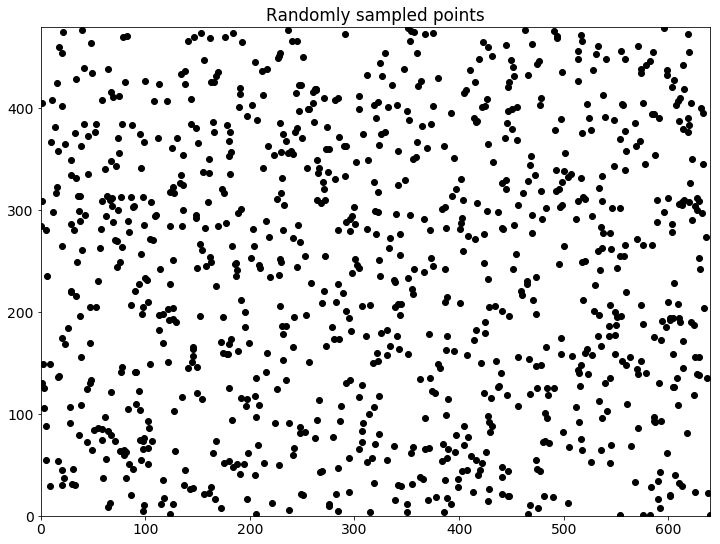

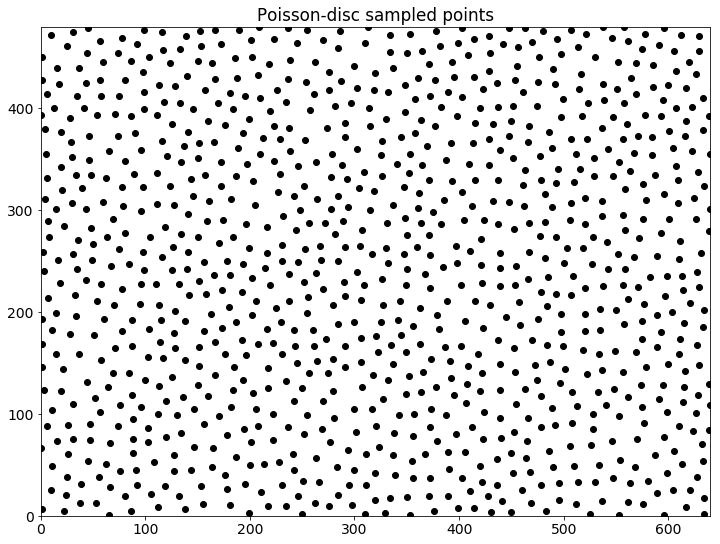

In [17]:
plot_scatter(pts_random, x, y, 'Randomly sampled points')
plot_scatter(pts_poisson, x, y, 'Poisson-disc sampled points')

### Voronoi Diagrams

To visualize how many pixels a single point is representative of we can use areas of Voronoi regions belonging to each selected (x,y) coordinate. The difference in area sizes is even more obvious when plotting only finite regions whose all vertices are within image boundaries.

In [18]:
vor_random = Voronoi(pts_random)
vor_poisson = Voronoi(pts_poisson)

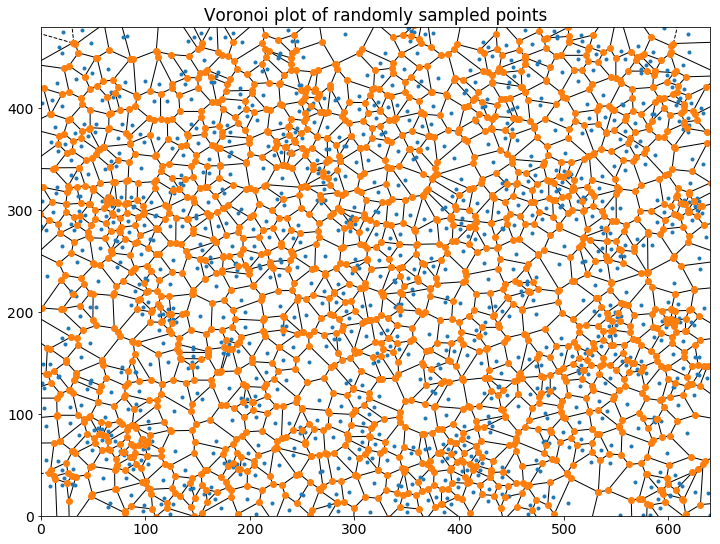

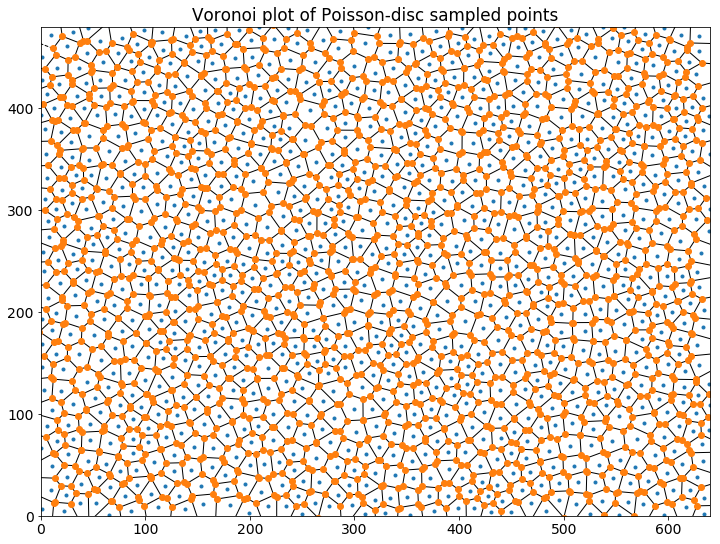

In [19]:
plot_vor(vor_random, x, y, 0, 'Voronoi plot of randomly sampled points')
plot_vor(vor_poisson, x, y, 0, 'Voronoi plot of Poisson-disc sampled points')

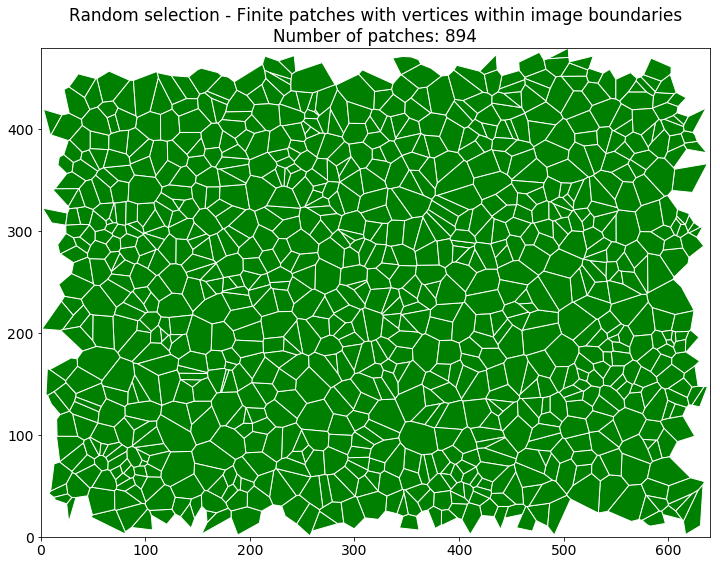

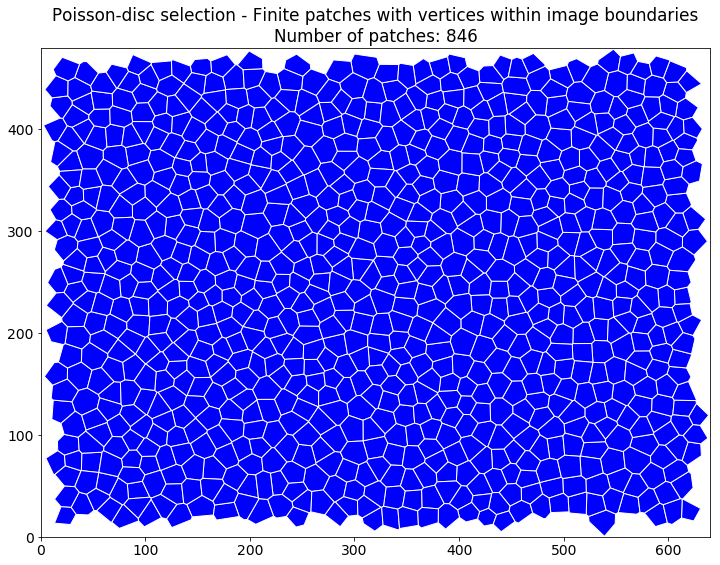

In [20]:
nv_random = vor_patches(vor_random, x, y, 'g', 'Random selection')
nv_poisson = vor_patches(vor_poisson, x, y, 'b', 'Poisson-disc selection')

### Distribution of Voronoi Regions Area Sizes

Plotting histograms showing the distribution of Voronoi region area sizes, it is apparent that uniform random selection is skewed, while Poisson-disc sampling exhibits even distribution.

In [21]:
sorted_nv_randon = sort_patch_vert(nv_random)
sorted_nv_poisson = sort_patch_vert(nv_poisson)
areas_random = patches_area(sorted_nv_randon)
areas_poisson = patches_area(sorted_nv_poisson)

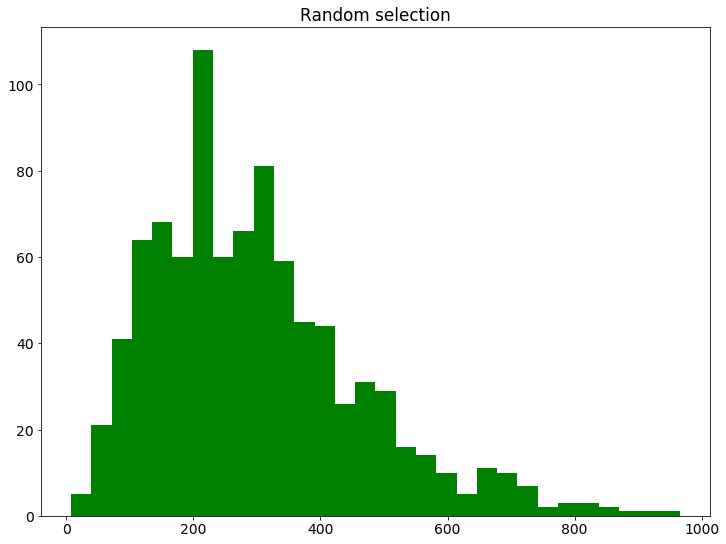

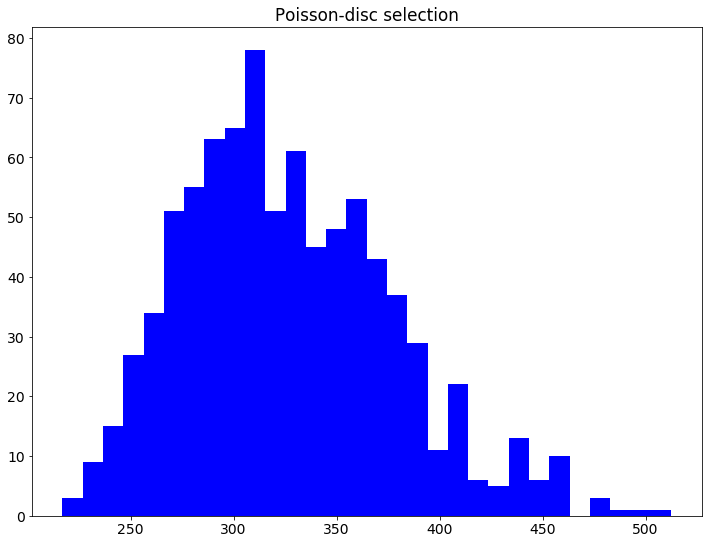

In [22]:
plot_hist(areas_random, 30, 'g', 'Random selection')
plot_hist(areas_poisson, 30, 'b', 'Poisson-disc selection')

## Conclusion

Poisson-disc sampling is superior in terms of evenness of distribution of sampling points and as being a representative subset of an image.